In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
train_dataset = datasets.MNIST(
                            root='./data',
                            train=True,
                            transform=transforms.ToTensor(),
                            download=True)
test_dataset = datasets.MNIST(
                            root='./data',
                            train=False,
                            transform=transforms.ToTensor(),
                            download=True)

In [11]:
batch_size = 10
train_loader = DataLoader(
                    dataset=train_dataset,
                    batch_size=batch_size,
                    shuffle=True)
test_loader = DataLoader(
                    dataset=test_dataset,
                    batch_size=batch_size,
                    shuffle=True)
# DataLoader存储数据格式为[[n个图片（28x28）],[n个答案]]
for images,label in train_loader:
    print(images.size()) # [[28x28二维数组],...,...，[28x28二维数组]]
    print("一个batch_size执行完了") # 执行完自动跳到下一个batch_size
    # 总数据量为60000，batch_size为10000，输出6次print
    break


torch.Size([10, 1, 28, 28])
一个batch_size执行完了


In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 输入1通道28x28
        self.conv1 = nn.Sequential( # 卷积模块
            nn.Conv2d( # 卷积层
                in_channels = 1, # 一通道，即原灰度图
                out_channels = 16, # 得到多少个特征图
                kernel_size = 5, # 卷积核大小（用5x5的区域提取特征图）
                stride = 1, # 步长
                padding = 2, # 填充（周围一圈补“0”）
            ),
            nn.ReLU(), # 激活函数
            nn.MaxPool2d( # 池化层
                kernel_size=2 # 池化核大小（在2x2区域取最大特征值）
            )
        ) # 得到16通道14x14，[(原图像素-卷积核大小+2*填充)/步长+1]/池化核大小
        
        # 输入16通道14x14
        self.conv2 = nn.Sequential( # 卷积模块
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ) # 得到32通道7x7，[(原图像素-卷积核大小+2*填充)/步长+1]/池化核大小
        self.fc1 = nn.Linear(32*7*7, 200)
        self.fc2 = nn.Linear(200, 100)
        self.out = nn.Linear(100, 10) # 全连接层，输出10个类别

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1) # 结果为(batch_size, 32*7*7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)


In [13]:
def load():
    try:
        net.load_state_dict(torch.load('CNN-MNIST.pkl'))
        print("加载成功")
    except:
        print("加载失败")

load()

加载成功


In [14]:
# 实例化模型
net = CNN()
# 损失函数
criterion = nn.CrossEntropyLoss()
# 学习率
lr = 0.001

In [15]:
def test():
    net.eval()
    total = len(test_dataset)
    correct = 0
    with torch.no_grad():
        for i,(images,labels) in enumerate(test_loader):
            correct_ans = labels.tolist()
            predicted = torch.max(net(images).data,1).indices.tolist()
            for j in range(len(correct_ans)):
                if correct_ans[j] == predicted[j]:
                    correct += 1
    return correct/total


print(f"正确率为{test()*100}%")

正确率为9.58%


In [16]:
def start(epochs,lr):
    max_accurate = 0
    for epoch in range(epochs):
        net.train()
        total_loss = 0
        for i,(images,labels) in enumerate(train_loader):
            # 前向传播
            output = net(images)
            # 计算损失
            loss = criterion(output, labels)
            # 优化器
            optimizer = optim.Adam(net.parameters(), lr=lr)
            # 梯度清零
            optimizer.zero_grad()
            # 反向传播
            loss.backward()
            # 更新参数
            optimizer.step()
            # 累加损失
            total_loss += loss.item()
        
        # 每训练一个epoch，计算一次正确率
        accurate = test() # 注意执行之后，模型被设置成了eval模式
        if accurate > max_accurate:
            max_accurate = accurate
            torch.save(net.state_dict(), 'CNN-MNIST.pkl')
            print(f"保存成功，当前最高正确率为{max_accurate*100}%")
        
        # 每训练一个epoch，打印一次损失
        print(f'{epoch}: loss {total_loss}')

start(30,lr)

正确答案为:5
预测答案为:5


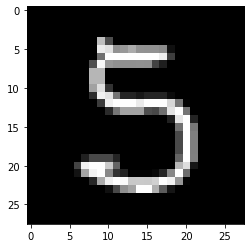

正确答案为:1
预测答案为:8


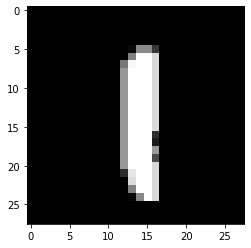

正确答案为:1
预测答案为:1


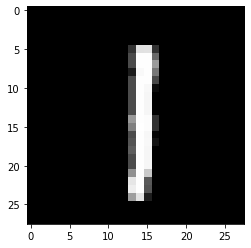

In [180]:
def show(n=1):
    net.eval()
    for i in range(n):
        images,labels = next(iter(test_loader))
        print(f"正确答案为:{labels[0]}")
        print(f"预测答案为:{torch.max(net(images[:1,:,:,:]),1).indices.item()}")
        plt.imshow(images[0][0], cmap='gray')
        plt.show()

show(3)